# Inspect the `ETL2` dataset

## Prerequisite

Get and unzip the `ETL2` dataset as show below.

```
ETL2
├── ETL2INFO
├── ETL2_1
├── ETL2_2
├── ETL2_3
├── ETL2_4
└── ETL2_5
```

In [1]:
import os
import io
import json

# external dependencies
import bitstring

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image
import IPython.display as display

# local modules
import shared

In [3]:
part_filepaths = [    
    'ETL2/ETL2_1',
    'ETL2/ETL2_2',
    'ETL2/ETL2_3',
    'ETL2/ETL2_4',
    'ETL2/ETL2_5',
]

# the code below is for Restart and Run All people (include me)
for part_filepath in part_filepaths:
    if not os.path.exists(part_filepath):
        raise Exception(part_filepath, 'does not exist!')

# Take a look a sample file

In [4]:
sample_filepath = part_filepaths[0]
print(sample_filepath)

'ETL2/ETL2_1'

Unpack the record as shown in the specification.

http://etlcdb.db.aist.go.jp/specification-of-etl-2

In [8]:
IMG_WIDTH = 60
IMG_HEIGHT = 60

bitstring_unpack_str = ','.join([
    'int:36', # Serial Index - [0]
    'uint:6', # Source ('A': Mincho Newspaper, 'B': Gothic Newspaper, 'C': Mincho Patent, 'D': Gothic Patent) - [1]
    'pad:30', # padding bits - no index as they are skipped
    '6*uint:6', # Class ('KANJI': kanji, 'EIJI': roman alphabets, 'HRKANA': hiragana, 'KTKANA': katakana, 'KIGO': special characters, 'SUUJI': numbers) - [2:8]
    '6*uint:6', # Font ('MINCHO', 'GOTHIC') - [8:14]
    'pad:24', # padding bits
    '2*uint:6', # CO-59 Code - [14:16]
    'pad:180', # padding bits
    'bytes:2700', # 6-bit-depth image of 60 x 60 = 3600 pixels - [16]
])

In [ ]:
infile = bitstring.ConstBitStream(filename=sample_filepath)
unpacked_data = infile.readlist(bitstring_unpack_str)

print(type(unpacked_data), len(unpacked_data))
print(unpacked_data[:-1])

In [10]:
print(
    unpacked_data[0],
    shared.T56(unpacked_data[1]),
    ''.join(map(shared.T56, unpacked_data[2:8])),
    ''.join(map(shared.T56, unpacked_data[8:14])),
    shared.CO59[tuple(unpacked_data[14:16])],
)

1 A KANJI  MINCHO 上


In [11]:
class ETL2Record:
    def __init__(
        self,
        index: int, # the Serial Index in the record
        source: str, # the source material that the record has been scanned from
        character_type: str, # enum type: 'KANJI', 'EIJI', 'HRKANA', 'KTKANA', 'KIGO', 'SUUJI'
        font: str, # e.g. "('MINCHO', 'GOTHIC')"
        unicode_char: str, # e.g. あ
        image: bytes, # PNG encoded image
    ):
        self.index = index
        self.source = source
        self.character_type = character_type
        self.font = font
        self.unicode_char = unicode_char
        self.image = image

    def __repr__(self):
        return repr(self.__dict__)

# All the images are 6-bit depth 60x60 pixels images

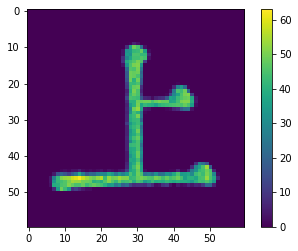

In [12]:
pil_image = Image.frombytes('F', (IMG_WIDTH, IMG_HEIGHT), record[16], 'bit', 6)

np_img = np.array(pil_image)

plt.imshow(np_img)
plt.colorbar()

# Convert image to grayscale `[0-255]` range

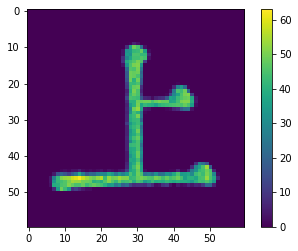

In [13]:
pil_image = pil_image.convert('L')
np_img = np.array(pil_image)

plt.imshow(np_img)
plt.colorbar()

In [15]:
buffer = io.BytesIO()
pil_image.save(buffer, format='PNG')
png_encoded_image = buffer.getvalue()

In [16]:
pil_image = Image.frombytes('F', (IMG_WIDTH, IMG_HEIGHT), record[16], 'bit', 6)
pil_image = pil_image.convert('L')

buffer = io.BytesIO()
pil_image.save(buffer, format='PNG')
png_encoded_image = buffer.getvalue()

etl2_record = ETL2Record(
    index=record[0],
    source=shared.T56(record[1]),
    character_type=''.join(map(shared.T56, record[2:8])),
    font=''.join(map(shared.T56, record[8:14])),
    unicode_char=shared.CO59[tuple(record[14:16])],
    image=png_encoded_image,
)

etl2_record

{'index': 1, 'source': 'A', 'character_type': 'KANJI ', 'font': 'MINCHO', 'unicode_char': '上', 'image': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00<\x00\x00\x00<\x08\x00\x00\x00\x00\x1f\x97\x86\xae\x00\x00\x02\x12IDATx\x9c\xed\x95mk\xd4@\x10\xc7\xe7i7\xc9\xb5\x9cT\xad-\xf5\x01\xbf\xffG\x12\n\x15\x04\xc1*"w\xd7\\\xb2\xb33\xbe\xf0\xae\x90\xd6N\x8f\x08\xbe\xbay\x13\x92\xff\xfc\xb2;\xff\x9d\xdd\x058\xc61\xfe%0s\xac\x07Z\xfbv\xa9\xb7\xb7\xf5\xe9\x04zZ\xe2K\x1f\xec\xf2c\x90\x11H@\xc646i\x16\x9cJr\x17\xd2Y0.2e\xb8\x99W\xf38\x92\xe0j\xfdtB\x04\xd7\r\x16\xdf\x06,H\xa0)\xbb\x07\x15\xc7n\x03\x80\x86z$\x1ale\xf6\xc8:\x92\xfa\xfd\xdb_z1\xaa\xd9=c\xbf\x7fi\xce\x9b\xd5\xadO\x13"\xb8\x18\x15\xdb\xe7\xbd<\xb3%|\x9b&\x84\xed\xc9\xb6\xff9v\xb2%|\x7fz\xf8\xc8\x89\xd4\x1bu\x15\xc2\xf6\xb5e4\xbc\xba\x9e\xf4[8\xed\x02\xdd\x07\x04e2\xd80\n\x02M]\x8b`+\t\xd7\xc9\\\x13a\x83X\xb8\xde[\xf0<\x8c\xe3\x92\xf1\x93W\x00@\x14\xea\x12~?\x1cv.\xfd\xaa:\x00\x80\xfb\x08\x8f\xdb<r\x1b[_\x90\x07\ta\xef\xba\x0fc\xa4G\xb

# That's all for inspecting a single record in the dataset.

`XFormat` is my custom data serialization format. I created this format because I don't want to use `JSON` or `TFRecord` (`protobuf`) for various limitations.

In [17]:
records_metadata = []
etl2_serialized_dataset_filepath = f'etl2{shared.XFormat.EXTENSION}'

if os.path.exists(etl2_serialized_dataset_filepath):
    raise Exception(etl2_serialized_dataset_filepath + ' is already existed!')

with open(etl2_serialized_dataset_filepath, mode='wb') as out_stream:
    pbar = tqdm(part_filepaths)
    for filename in pbar:

        infile = bitstring.ConstBitStream(filename=filename)

        while True:
            try:
                unpacked_data = infile.readlist(bitstring_unpack_str)
            except:
                # TODO properly check for end of file
                # print(unpacked_data)
                # traceback.print_exc()
                break

            pil_image = Image.frombytes('F', (IMG_WIDTH, IMG_HEIGHT), unpacked_data[16], 'bit', 6)
            pil_image = pil_image.convert('L')

            buffer = io.BytesIO()
            pil_image.save(buffer, format='PNG')
            png_encoded_image = buffer.getvalue()

            etl2_record = ETL2Record(
                index=unpacked_data[0],
                source=shared.T56(unpacked_data[1]),
                character_type=''.join(map(shared.T56, unpacked_data[2:8])),
                font=''.join(map(shared.T56, unpacked_data[8:14])),
                unicode_char=shared.CO59[tuple(unpacked_data[14:16])],
                image=png_encoded_image,
            )

            record_datatype, serialized_record = shared.XFormat.serialize_obj(etl2_record.__dict__)
            record_byte_count = len(serialized_record)
            record_seek_start = out_stream.tell()

            out_stream.write(record_datatype)
            out_stream.write(shared.XFormat.serialize_int(record_byte_count))
            out_stream.write(serialized_record)

            record_seek_end = out_stream.tell()
            
            record_metadata = {
                'index': etl2_record.index,
                'source': etl2_record.source,
                'character_type': etl2_record.character_type,
                'font': etl2_record.font,
                'unicode_char': etl2_record.unicode_char,
                'seek_start': record_seek_start,
                'seek_end': record_seek_end,
            }
            
            records_metadata.append(record_metadata)
            
            pbar.set_description(f'{filename} - {etl2_record.index}')

ETL2/ETL2_5 - 57600: 100%|████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.76s/it]


In [18]:
metadata_filepath = 'etl2-metadata.json'
if os.path.exists(metadata_filepath):
    raise Exception(metadata_filepath + 'is already existed!')

with open(metadata_filepath, mode='w', encoding='utf-8') as out_stream:
    json.dump(records_metadata, out_stream, ensure_ascii=False, indent='\t')